In [2]:
import torch
import numpy as np
from idem_net_mnist import IdemNetMnist
from idem_net_celeba import IdemNetCeleba
from data_loader import load_MNIST, load_CelebA
import matplotlib.pyplot as plt
from plot_utils import plot_generation
from ignite.metrics import FID

/opt/conda/envs/myenv/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [3]:

run_id = "celeba20241113-154812"
epoch_num = "_final.pth"

device = torch.device("cpu")

checkpoint_path = f"checkpoints/{run_id}/{epoch_num}"
device

device(type='cpu')

In [4]:
if "celeba" in run_id:
  model = IdemNetCeleba(3) # IdemNetMnist()
else:
  model = IdemNetMnist()

state_dict = torch.load(checkpoint_path, weights_only=True, map_location=device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:
model.load_state_dict(state_dict)
# model.eval()

<All keys matched successfully>

In [6]:
# Get a batch of real images for FID score calculation (CelebA images)
data_loader, test_loader = load_CelebA(batch_size=32)
test_imgs, _ = next(iter(data_loader))
test_imgs = test_imgs.to(device)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch

model.to(device)

z_gen = torch.randn_like(test_imgs)  
with torch.no_grad(): 
    f_z = model(z_gen) 
    ff_z = model(f_z)  

# Normalize the images to [0, 1] for visualization
z_gen = (z_gen - z_gen.min()) / (z_gen.max() - z_gen.min())
f_z = (f_z - f_z.min()) / (f_z.max() - f_z.min())
ff_z = (ff_z - ff_z.min()) / (ff_z.max() - ff_z.min())

def plot_generated_images(z_gen, f_z, ff_z, device, num_imgs=3):
    # Convert the tensors to NumPy arrays for visualization
    z_gen_np = z_gen.cpu().numpy()
    f_z_np = f_z.cpu().numpy()
    ff_z_np = ff_z.cpu().numpy()

    # If the images are in [batch_size, channels, height, width], transpose them to [batch_size, height, width, channels]
    z_gen_np = np.transpose(z_gen_np, (0, 2, 3, 1))
    f_z_np = np.transpose(f_z_np, (0, 2, 3, 1))
    ff_z_np = np.transpose(ff_z_np, (0, 2, 3, 1))

    # Create a plot with subplots (grid)
    fig, axes = plt.subplots(1, 3, figsize=(8, 8))  # 3x3 grid for 9 images
    axes = axes.ravel()  # Flatten the axes array

    # Plot the random noise, f_z, and ff_z
    for i in range(num_imgs):
        # Plot z_gen (noise)
        axes[i].imshow(z_gen_np[i])  # Display the noise image
        axes[i].axis('off')  # Turn off axis labels
        axes[i].set_title(f"Noise {i+1}")
        

    # Plot f_z
    fig, axes = plt.subplots(1, 3, figsize=(8, 8))  # 1x3 grid for 3 images
    axes = axes.ravel()

    for i in range(num_imgs):
        axes[i].imshow(f_z_np[i])  # Display the generated image
        axes[i].axis('off')
        axes[i].set_title(f"f_z {i+1}")
        

    # Plot ff_z
    fig, axes = plt.subplots(1, 3, figsize=(8, 8))  # 1x3 grid for 3 images
    axes = axes.ravel()

    for i in range(num_imgs):
        axes[i].imshow(ff_z_np[i])  # Display the second set of generated images
        axes[i].axis('off')
        axes[i].set_title(f"ff_z {i+1}")
        
    plt.show()


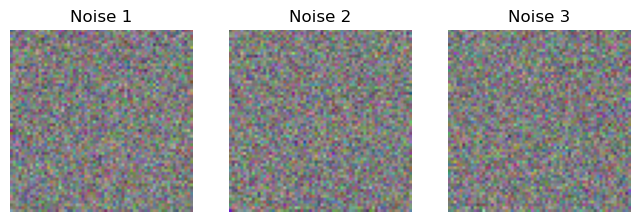

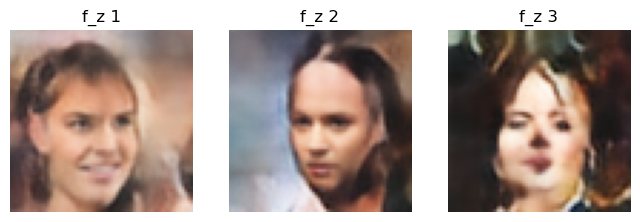

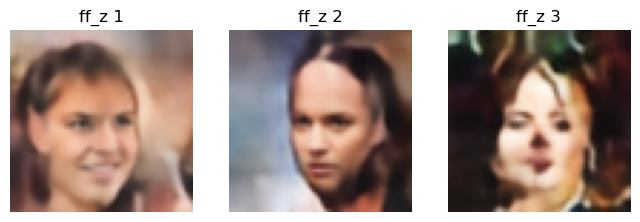

In [8]:
plot_generated_images(z_gen, f_z, ff_z, device)

In [ ]:
import torch
import numpy as np
from ignite.metrics import FID
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models.inception import inception_v3

# Preprocessing function for images (resize and normalize)
def preprocess_images(images, target_size=299):
    # Resize using interpolate (for tensors)
    images_resized = F.interpolate(images, size=(target_size, target_size), mode='bilinear', align_corners=False)
    
    # Normalize images to [-1, 1] (assuming input range is [0, 1])
    images_normalized = (images_resized - 0.5) / 0.5  # Assuming the images are in range [0, 1]
    
    return images_normalized

# Instantiate the InceptionV3 model for FID calculation
def get_inception_model():
    model = inception_v3(weights=True, transform_input=False)
    model.eval()  # Set to eval mode for inference
    return model

# Function to compute FID score between f_z and ff_z
def compute_fid(f_z, ff_z):
    device = torch.device('cpu')  # Switch to CPU
    f_z_preprocessed = preprocess_images(f_z).to(device)
    ff_z_preprocessed = preprocess_images(ff_z).to(device)


    inception_model = get_inception_model().to(device)

    # Extract features from the generated images
    f_z_features = inception_model(f_z_preprocessed)
    ff_z_features = inception_model(ff_z_preprocessed)

    # Compute FID score (Inception model will output activations, which we use)
    fid_score = FID()(f_z_features, ff_z_features)
    return fid_score

# Example of usage: compute FID between f_z and ff_z
fid_score = compute_fid(f_z, ff_z)

# InceptionV3 model to extract features
device = f_z.device()
print(f"FID score between f_z and ff_z: {fid_score.item()}")

In [ ]:
import torch
import numpy as np
from torchvision.models import inception_v3
import torch.nn.functional as F
from sklearn.decomposition import PCA
from scipy.linalg import sqrtm


def preprocess_images(images, target_size=299):
    # Resize using interpolate (for tensors)
    images_resized = F.interpolate(images, size=(target_size, target_size), mode='bilinear', align_corners=False)
    
    # Normalize images to [-1, 1]
    images_normalized = (images_resized - 0.5) / 0.5  # Assuming the images are in range [0, 1]
    
    return images_normalized


def get_inception_model():
    model = inception_v3(weights="IMAGENET1K_V1", transform_input=False)
    model.Mixed_7c.register_forward_hook(_hook_fn)  # Attach the hook to the last pooling layer
    model.fc = torch.nn.Identity()  # Remove the classification head
    model.eval()
    return model

# Hook function to capture the output of the last pooling layer
def _hook_fn(module, input, output):
    global pooled_features
    pooled_features = output


def extract_features(images, model):
    global pooled_features
    pooled_features = None  # Reset the global variable
    
    # Register the hook on the last pooling layer
    last_pooling_layer = model.Mixed_7c  # InceptionV3's last pooling layer
    hook_handle = last_pooling_layer.register_forward_hook(_hook_fn)
    
    with torch.no_grad():
        model(images)  # Forward pass to trigger the hook
    
    # Remove the hook after the forward pass
    hook_handle.remove()
    
    # Flatten the features and return
    return pooled_features.view(pooled_features.size(0), -1)  # Flatten the output


# Used because the feature space is too big (TODO: consider doing batch wise instead of applying PCA)
def reduce_dimensionality(features, n_components=None):
    features_np = features.detach().cpu().numpy()
    max_components = min(features_np.shape[0], features_np.shape[1])
    if n_components is None or n_components > max_components:
        n_components = max_components
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features_np)
    return reduced_features

# Get the mean and covariance of the feature space (last pooling layer)
def compute_statistics(features):
    reduced_features = reduce_dimensionality(features)
    mu = np.mean(reduced_features, axis=0)
    sigma = np.cov(reduced_features, rowvar=False)
    return mu, sigma

# Compute the Fréchet distance
def frechet_distance(mu1, sigma1, mu2, sigma2):
    diff = mu1 - mu2
    covmean = sqrtm(sigma1 @ sigma2)
    # Numerical stability: if covmean has imaginary values, take only the real part
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return np.sum(diff**2) + np.trace(sigma1 + sigma2 - 2 * covmean)

# Function to compute FID score between f_z and ff_z
def compute_fid(f_z, ff_z):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Preprocess
    f_z_preprocessed = preprocess_images(f_z).to(device)
    ff_z_preprocessed = preprocess_images(ff_z).to(device)


    inception_model = get_inception_model().to(device)

    # Extract features using the last pooling layer
    f_z_features = extract_features(f_z_preprocessed, inception_model)
    ff_z_features = extract_features(ff_z_preprocessed, inception_model)

    # Compute statistics
    mu1, sigma1 = compute_statistics(f_z_features)
    mu2, sigma2 = compute_statistics(ff_z_features)

    # Calculate FID
    fid_score = frechet_distance(mu1, sigma1, mu2, sigma2)
    return fid_score

# usage between two random tensors
img_1 = torch.rand(16, 3, 64, 64)  # Replace with actual data
img_2 = torch.rand(16, 3, 64, 64)  # Replace with actual data

fid_score = compute_fid(img_1, img_2)
print(f"FID score between f_z and ff_z: {fid_score}")